In [1]:
import numpy as np
import pandas as pd
df=pd.read_csv('train.csv')
df=df.drop(columns='image_link')
df.sample(6)

,sample_id,catalog_content,price
12588,93320,Item Name: Nature's Path Organic Gluten-Free C...,4.570
73497,272397,"Item Name: V8 Acai Mixed Berry, 46 oz. Bottle\...",6.745
69966,127533,Item Name: Golden Island Korean BBQ Pork 5Pack...,21.650
29961,174534,Item Name: Good Health Veggie Stix (10x6.75 Oz...,61.010
37938,250567,Item Name: Big Train Reduced Sugar Mocha Blend...,27.380
17578,134250,"Item Name: Nut Harvest, Frtnut Trail Mix, 2.25...",1.780


In [365]:
import re
import pandas as pd
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def clean_text(text):
    if pd.isna(text): return ""
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^A-Za-z0-9\s]", " ", text.lower())
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['tokens'] = df['catalog_content'].apply(clean_text)
#df['tokens']=df['tokens'].apply(lambda t:' '.join(t))

In [366]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [367]:
df['tokens']

0        item name la victoria green taco sauce mild 12...
1        item name salerno cookies the original butter ...
2        item name bear creek hearty soup bowl creamy c...
3        item name judee s blue cheese powder 11 25 oz ...
4        item name kedem sherry cooking wine 12 7 ounce...
                               ...                        
74995    item name ice breakers spearmint sugar free mi...
74996    item name davidson s organics vanilla essence ...
74997    item name jolly rancher hard candy blue raspbe...
74998    item name nescafe dolce gusto capsules caramel...
74999    item name pimenton de la vera picante 2 47 oun...
Name: tokens, Length: 75000, dtype: object

In [368]:
df['brand'] = df['tokens'].str.extract(r'^\w+\s+\w+\s+([A-Za-z]+(?:\s+[A-Za-z]+)?)')
df['num_gb'] = df['tokens'].str.extract(r'(\d+)\s?gb', expand=False).astype(float)
df['num_ml'] = df['tokens'].str.extract(r'(\d+)\s?ml', expand=False).astype(float)
df['num_inch'] = df['tokens'].str.extract(r'(\d+)\s?inch', expand=False).astype(float)
df['num_watt'] = df['tokens'].str.extract(r'(\d+)\s?w', expand=False).astype(float)
df['num_litre'] = df['tokens'].str.extract(r'(\d+)\s?l', expand=False).astype(float)
df['num'] = df['tokens'].str.extract(r'(\d+)', expand=False).astype(float)
df = df.fillna(0)

In [ ]:
vectorizer=TfidfVectorizer(max_features=8000,stop_words='english')
#df['brand'] = df['brand'].fillna("").astype(str)
x_tfidf=vectorizer.fit_transform(df['tokens']).toarray()                             1

In [66]:
x_tfidf_dense=x_tfidf.todense()

AttributeError: 'numpy.ndarray' object has no attribute 'todense'

In [255]:
import gensim.downloader as api
fasttext = api.load("fasttext-wiki-news-subwords-300")
print("✅ FastText model loaded!")

✅ FastText model loaded!


In [300]:
def fasttext_sentence_vector(sentence,model,dim=300):
    words=sentence.split()
    vectors=[model[word] for word in words if word in model]
    if len(vectors)==0:
        return np.zeros(dim)
    return np.mean(vectors,axis=0)

df['brand'] = df['brand'].fillna("").astype(str)
df['embedding']=df['tokens'].apply(lambda x:fasttext_sentence_vector(x,fasttext))
#x_fasttext=np.array([fasttext_sentence_vector(sentence,fasttext) for sentence in df['brand']])

In [332]:
from sentence_transformers import SentenceTransformer
print("🔍 Generating sentence embeddings ...")
model = SentenceTransformer('all-MiniLM-L6-v2')

#df['brand'] = df['brand'].fillna("").astype(str)
embeddings = model.encode(df['tokens'].tolist(), show_progress_bar=True)
emb_df = pd.DataFrame(embeddings)
emb_df.columns = [f"emb_{i}" for i in range(emb_df.shape[1])]

🔍 Generating sentence embeddings ...


Batches: 100%|██████████| 2344/2344 [04:31<00:00,  8.64it/s]  


In [370]:
df

,sample_id,catalog_content,price,tokens,brand,num_gb,num_ml,num_inch,num_watt,num_litre,num
0,33127,"Item Name: La Victoria Green Taco Sauce Mild, ...",4.890,item name la victoria green taco sauce mild 12...,la victoria,0.0,0.0,0.0,0.0,0.0,12.0
1,198967,"Item Name: Salerno Cookies, The Original Butte...",13.120,item name salerno cookies the original butter ...,salerno cookies,0.0,0.0,0.0,0.0,0.0,8.0
2,261251,"Item Name: Bear Creek Hearty Soup Bowl, Creamy...",1.970,item name bear creek hearty soup bowl creamy c...,bear creek,0.0,0.0,0.0,0.0,1.0,1.0
3,55858,Item Name: Judee’s Blue Cheese Powder 11.25 oz...,30.340,item name judee s blue cheese powder 11 25 oz ...,judee s,0.0,0.0,0.0,0.0,0.0,11.0
4,292686,"Item Name: kedem Sherry Cooking Wine, 12.7 Oun...",66.490,item name kedem sherry cooking wine 12 7 ounce...,kedem sherry,0.0,0.0,0.0,0.0,0.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...
74995,41424,Item Name: ICE BREAKERS Spearmint Sugar Free M...,10.395,item name ice breakers spearmint sugar free mi...,ice breakers,0.0,0.0,0.0,0.0,0.0,1.0
74996,35537,"Item Name: Davidson's Organics, Vanilla Essenc...",35.920,item name davidson s organics vanilla essence ...,davidson s,0.0,0.0,0.0,1976.0,2.0,100.0
74997,249971,Item Name: Jolly Rancher Hard Candy - Blue Ras...,50.330,item name jolly rancher hard candy blue raspbe...,jolly rancher,0.0,0.0,0.0,0.0,5.0,5.0
74998,188322,Item Name: Nescafe Dolce Gusto Capsules - CARA...,15.275,item name nescafe dolce gusto capsules caramel...,nescafe dolce,0.0,0.0,0.0,2.0,0.0,16.0


In [302]:
x_fasttext=np.vstack(df['embedding'].values)
x_pca=PCA(n_components=300,random_state=42).fit_transform(x_fasttext)

In [334]:
x_pca=PCA(n_components=300,random_state=42).fit_transform(embeddings)

In [371]:
x_pca=PCA(n_components=300,random_state=42).fit_transform(x_tfidf)                             #2

In [372]:
x_pca_df = pd.DataFrame(x_pca)
x_pca_df.columns = [f"pca_{i}" for i in range(x_pca_df.shape[1])]

In [373]:
kmeans=KMeans(n_clusters=121,random_state=42)
df['automated_category_id']=kmeans.fit_predict(x_pca)

In [374]:
df['automated_category_id'].value_counts()

automated_category_id
87    6034
26    3099
9     2773
67    1740
68    1740
      ... 
15     135
57     129
35     123
19      91
47      46
Name: count, Length: 121, dtype: int64

In [375]:
df

,sample_id,catalog_content,price,tokens,brand,num_gb,num_ml,num_inch,num_watt,num_litre,num,automated_category_id
0,33127,"Item Name: La Victoria Green Taco Sauce Mild, ...",4.890,item name la victoria green taco sauce mild 12...,la victoria,0.0,0.0,0.0,0.0,0.0,12.0,4
1,198967,"Item Name: Salerno Cookies, The Original Butte...",13.120,item name salerno cookies the original butter ...,salerno cookies,0.0,0.0,0.0,0.0,0.0,8.0,25
2,261251,"Item Name: Bear Creek Hearty Soup Bowl, Creamy...",1.970,item name bear creek hearty soup bowl creamy c...,bear creek,0.0,0.0,0.0,0.0,1.0,1.0,94
3,55858,Item Name: Judee’s Blue Cheese Powder 11.25 oz...,30.340,item name judee s blue cheese powder 11 25 oz ...,judee s,0.0,0.0,0.0,0.0,0.0,11.0,76
4,292686,"Item Name: kedem Sherry Cooking Wine, 12.7 Oun...",66.490,item name kedem sherry cooking wine 12 7 ounce...,kedem sherry,0.0,0.0,0.0,0.0,0.0,12.0,68
...,...,...,...,...,...,...,...,...,...,...,...,...
74995,41424,Item Name: ICE BREAKERS Spearmint Sugar Free M...,10.395,item name ice breakers spearmint sugar free mi...,ice breakers,0.0,0.0,0.0,0.0,0.0,1.0,81
74996,35537,"Item Name: Davidson's Organics, Vanilla Essenc...",35.920,item name davidson s organics vanilla essence ...,davidson s,0.0,0.0,0.0,1976.0,2.0,100.0,57
74997,249971,Item Name: Jolly Rancher Hard Candy - Blue Ras...,50.330,item name jolly rancher hard candy blue raspbe...,jolly rancher,0.0,0.0,0.0,0.0,5.0,5.0,67
74998,188322,Item Name: Nescafe Dolce Gusto Capsules - CARA...,15.275,item name nescafe dolce gusto capsules caramel...,nescafe dolce,0.0,0.0,0.0,2.0,0.0,16.0,87


In [377]:
df.where(df['automated_category_id']==26).dropna()

,sample_id,catalog_content,price,tokens,brand,num_gb,num_ml,num_inch,num_watt,num_litre,num,automated_category_id
5,9259.0,"Item Name: Member's Mark Member's Mark, Basil,...",18.500,item name member s mark member s mark basil 6 ...,member s,0.0,0.0,0.0,0.0,2.0,6.0,26.0
52,278964.0,"Item Name: Carbquik Baking Mix, 3 Lb (48 Oz) (...",30.475,item name carbquik baking mix 3 lb 48 oz pack ...,carbquik baking,0.0,0.0,0.0,0.0,3.0,3.0,26.0
62,25549.0,"Item Name: V8 Juice, 11.5-Ounce Bottles (Pack ...",12.795,item name v8 juice 11 5 ounce bottles pack of ...,v,0.0,0.0,0.0,0.0,0.0,8.0,26.0
90,181347.0,Item Name: Banana Boat Sunscreen Ultra Mist Dr...,11.135,item name banana boat sunscreen ultra mist dry...,banana boat,0.0,0.0,0.0,0.0,0.0,8.0,26.0
167,93888.0,"Item Name: Hall's Penuche Fudge, 1 Pound\nBull...",29.950,item name hall s penuche fudge 1 pound bullet ...,hall s,0.0,0.0,0.0,0.0,0.0,1.0,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...
74861,42844.0,"Item Name: S&B Premium Wasabi Paste in Tube, 1...",7.490,item name s b premium wasabi paste in tube 1 5...,s b,0.0,0.0,0.0,0.0,0.0,1.0,26.0
74916,291533.0,Item Name: Mathew Walkers Classic Christmas Pu...,18.780,item name mathew walkers classic christmas pud...,mathew walkers,0.0,0.0,0.0,0.0,0.0,400.0,26.0
74958,285486.0,"Item Name: Bakers Coconut Angel Flakes, 7 oz\n...",5.695,item name bakers coconut angel flakes 7 oz bul...,bakers coconut,0.0,0.0,0.0,0.0,0.0,7.0,26.0
74963,252379.0,Item Name: Loma Linda - Plant-Based Meats (Chi...,34.490,item name loma linda plant based meats chili 2...,loma linda,0.0,0.0,0.0,0.0,1.0,20.0,26.0


In [378]:
# --- Merge embeddings + category + simple text stats
X = pd.concat([x_pca_df,df[['num_gb','num_ml','num_inch','num_watt','num_litre','num']].reset_index(drop=True),
               df[['automated_category_id']].reset_index(drop=True)], axis=1)

X['word_count'] = df['tokens'].apply(lambda x: len(x.split()))
X['char_length'] = df['tokens'].apply(len)
y = df['price'].values

print("✅ Embedding shape:", X.shape)

✅ Embedding shape: (75000, 309)


In [266]:
# --- Merge embeddings + category + simple text stats
X = pd.concat([emb_df,
               df[['automated_category_id']].reset_index(drop=True)], axis=1)

X['word_count'] = df['tokens'].apply(lambda x: len(x.split()))
X['char_length'] = df['tokens'].apply(len)
y = df['price'].values

print("✅ Embedding shape:", X.shape)

✅ Embedding shape: (75000, 387)


In [379]:
X

,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,...,pca_299,num_gb,num_ml,num_inch,num_watt,num_litre,num,automated_category_id,word_count,char_length
0,-0.063929,-0.054288,-0.238066,-0.079177,-0.039862,0.026144,0.011717,0.047737,0.016883,0.008633,...,-0.012557,0.0,0.0,0.0,0.0,0.0,12.0,4,19,84
1,-0.074994,-0.033430,0.073381,0.073131,-0.037821,0.076854,0.024591,0.003692,0.101667,-0.050665,...,-0.011411,0.0,0.0,0.0,0.0,0.0,8.0,25,81,491
2,-0.084338,-0.022202,0.106328,-0.102163,-0.047574,0.116647,-0.077878,-0.081837,0.067846,-0.043105,...,-0.002788,0.0,0.0,0.0,0.0,1.0,1.0,94,61,315
3,-0.040104,-0.041327,0.051106,-0.042802,0.000245,-0.057091,-0.126178,-0.032427,0.039532,-0.040161,...,-0.006216,0.0,0.0,0.0,0.0,0.0,11.0,76,213,1272
4,-0.068852,-0.029095,-0.162266,-0.039752,-0.048021,0.047110,0.056418,0.022228,0.049463,-0.044879,...,-0.024087,0.0,0.0,0.0,0.0,0.0,12.0,68,29,142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74995,-0.028846,-0.022457,0.035875,0.090247,-0.022939,0.027832,0.002890,0.022345,-0.104510,-0.002789,...,0.014525,0.0,0.0,0.0,0.0,0.0,1.0,81,137,755
74996,0.297182,0.009394,0.036077,-0.075963,0.060079,-0.026703,0.234592,-0.214205,-0.093259,0.034482,...,0.003973,0.0,0.0,0.0,1976.0,2.0,100.0,57,284,1658
74997,-0.039094,-0.033693,-0.095458,0.166249,-0.001341,0.002274,-0.005203,-0.045537,-0.120422,0.061945,...,0.032231,0.0,0.0,0.0,0.0,5.0,5.0,67,22,133
74998,-0.011106,0.054362,0.007934,0.038443,-0.022077,0.025685,-0.014339,-0.005932,0.011922,0.002941,...,0.002315,0.0,0.0,0.0,2.0,0.0,16.0,87,140,875


In [380]:
X['automated_category_id']=np.log1p(X['automated_category_id'])
X['char_length']=np.log1p(X['char_length'])
X['word_count']=np.log1p(X['word_count'])
X['num']=np.log1p(X['num'])

In [381]:
X

,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,...,pca_299,num_gb,num_ml,num_inch,num_watt,num_litre,num,automated_category_id,word_count,char_length
0,-0.063929,-0.054288,-0.238066,-0.079177,-0.039862,0.026144,0.011717,0.047737,0.016883,0.008633,...,-0.012557,0.0,0.0,0.0,0.0,0.0,2.564949,1.609438,2.995732,4.442651
1,-0.074994,-0.033430,0.073381,0.073131,-0.037821,0.076854,0.024591,0.003692,0.101667,-0.050665,...,-0.011411,0.0,0.0,0.0,0.0,0.0,2.197225,3.258097,4.406719,6.198479
2,-0.084338,-0.022202,0.106328,-0.102163,-0.047574,0.116647,-0.077878,-0.081837,0.067846,-0.043105,...,-0.002788,0.0,0.0,0.0,0.0,1.0,0.693147,4.553877,4.127134,5.755742
3,-0.040104,-0.041327,0.051106,-0.042802,0.000245,-0.057091,-0.126178,-0.032427,0.039532,-0.040161,...,-0.006216,0.0,0.0,0.0,0.0,0.0,2.484907,4.343805,5.365976,7.149132
4,-0.068852,-0.029095,-0.162266,-0.039752,-0.048021,0.047110,0.056418,0.022228,0.049463,-0.044879,...,-0.024087,0.0,0.0,0.0,0.0,0.0,2.564949,4.234107,3.401197,4.962845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74995,-0.028846,-0.022457,0.035875,0.090247,-0.022939,0.027832,0.002890,0.022345,-0.104510,-0.002789,...,0.014525,0.0,0.0,0.0,0.0,0.0,0.693147,4.406719,4.927254,6.628041
74996,0.297182,0.009394,0.036077,-0.075963,0.060079,-0.026703,0.234592,-0.214205,-0.093259,0.034482,...,0.003973,0.0,0.0,0.0,1976.0,2.0,4.615121,4.060443,5.652489,7.413970
74997,-0.039094,-0.033693,-0.095458,0.166249,-0.001341,0.002274,-0.005203,-0.045537,-0.120422,0.061945,...,0.032231,0.0,0.0,0.0,0.0,5.0,1.791759,4.219508,3.135494,4.897840
74998,-0.011106,0.054362,0.007934,0.038443,-0.022077,0.025685,-0.014339,-0.005932,0.011922,0.002941,...,0.002315,0.0,0.0,0.0,2.0,0.0,2.833213,4.477337,4.948760,6.775366


In [382]:
y

array([ 4.89 , 13.12 ,  1.97 , ..., 50.33 , 15.275, 28.24 ])

In [383]:
y1=np.log1p(y)

In [384]:
y1

array([1.773256  , 2.64759223, 1.08856195, ..., 3.93827538, 2.78963019,
       3.37553763])

In [385]:
trx=X[:74000]
tr_y=y1[:74000]

testx=X[0:7500]
testy=y1[0:7500]

In [397]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(X,y1,test_size=0.2,random_state=42)

In [398]:
from xgboost import XGBRegressor
xgb=XGBRegressor(n_estimators=2500,
    learning_rate=0.02,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.2,
    reg_lambda=0.4,
    tree_method='hist',
    random_state=42)
xgb.fit(x_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [399]:
x_val

,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,...,pca_299,num_gb,num_ml,num_inch,num_watt,num_litre,num,automated_category_id,word_count,char_length
26837,-0.070168,-0.028761,0.032928,-0.083108,-0.056766,0.054675,0.042750,0.188464,-0.060641,-0.037582,...,-0.039132,0.0,0.0,0.0,0.0,0.0,3.218876,4.753590,4.644391,6.324359
2592,0.465853,-0.026041,-0.009836,0.030436,-0.093684,-0.048638,-0.070857,0.055722,0.059568,0.058242,...,-0.007801,0.0,0.0,0.0,0.0,1.0,3.931826,2.639057,5.988961,7.763021
18359,-0.062192,-0.051574,0.058651,-0.073288,0.022868,-0.162053,0.094280,0.116602,-0.070167,-0.057043,...,0.037565,0.0,0.0,0.0,0.0,0.0,2.564949,4.304065,4.795791,6.577861
73292,-0.044622,-0.035311,-0.022376,-0.039402,-0.019337,0.033768,-0.022682,0.024594,0.006517,0.006753,...,-0.033436,0.0,0.0,0.0,0.0,0.0,2.833213,4.477337,4.465908,6.173786
60127,0.030805,0.064296,0.085343,-0.135096,-0.088899,0.153624,0.012720,0.132850,-0.052301,0.007753,...,-0.014769,0.0,0.0,0.0,0.0,0.0,3.258097,4.753590,4.219508,5.926926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57279,-0.012929,-0.012117,0.035184,0.013394,0.027226,-0.053157,-0.071030,-0.028889,-0.013686,0.020508,...,-0.020374,0.0,0.0,0.0,0.0,1.0,0.693147,4.779123,5.402677,7.264730
20713,-0.039016,-0.028426,-0.002958,0.060100,-0.008957,0.028901,-0.042772,-0.012513,-0.048956,0.004171,...,-0.012331,0.0,0.0,0.0,0.0,0.0,1.386294,4.762174,4.532599,6.274762
20057,-0.044992,-0.044643,-0.011374,-0.082937,-0.027179,0.022002,-0.071864,-0.052002,0.038765,0.032063,...,-0.001082,0.0,0.0,0.0,2.0,0.0,2.833213,3.713572,4.043051,5.693732
26268,-0.019014,-0.019727,-0.019017,0.022388,-0.000290,-0.080635,-0.155945,-0.039296,0.030236,-0.016181,...,-0.026548,0.0,0.0,0.0,0.0,7.0,1.098612,4.110874,6.513230,8.248529


In [400]:
y_val

array([2.57983797, 3.67731282, 2.93704328, ..., 1.46787435, 2.03208785,
       3.3304172 ])

In [401]:
y_xgb=xgb.predict(x_val)
np.expm1(y_xgb)

array([10.390783 , 32.28036  , 13.114296 , ...,  3.9053907, 15.577571 ,
       12.321542 ], dtype=float32)

In [402]:
y_xgb

array([2.4328046, 3.5049675, 2.6471882, ..., 1.5903348, 2.8080506,
       2.5893824], dtype=float32)

In [403]:
y_val

array([2.57983797, 3.67731282, 2.93704328, ..., 1.46787435, 2.03208785,
       3.3304172 ])

In [404]:
np.expm1(y_val)

array([12.195, 38.54 , 17.86 , ...,  3.34 ,  6.63 , 26.95 ])

In [405]:
def smape(y_true, y_pred):
    return np.mean(2*np.abs(y_true-y_pred)/(np.abs(y_true)+np.abs(y_pred)))*100

y_xgb=xgb.predict(x_val)
score = smape(np.expm1(y_val),np.expm1(y_xgb))
print("SMAPE:", score)

SMAPE: 55.130462423655736


In [406]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(np.expm1(y_val),np.expm1(y_xgb))*100

80.16997300253172

In [407]:
see=xgb.predict(testx)
score = smape(np.expm1(testy),np.expm1(see))
print("SMAPE:", score)
mean_absolute_percentage_error(np.expm1(testy),np.expm1(see))*100

SMAPE: 19.93072307245815


25.414048095295687

In [408]:
np.expm1(testy).min()

0.13

In [409]:
testy.max()

6.420939107676499

In [410]:
np.expm1(testy),np.expm1(see)

(array([  4.89,  13.12,   1.97, ...,  51.98, 231.98,   2.88]),
 array([  4.974611 ,  13.013683 ,   2.4871418, ...,  31.559671 ,
        236.50227  ,  17.780563 ], dtype=float32))

In [411]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
import numpy as np

train_data = lgb.Dataset(x_train, label=y_train)
val_data = lgb.Dataset(x_val, label=y_val)

params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'num_leaves': 60,
    'learning_rate': 0.07,
    #'feature_fraction': 0.9,
    #'bagging_fraction': 0.8,
    #'bagging_freq': 5,
    'verbose': -1,
    'n_estimators':2400
    #'max_depth':10
    #'random_state':42
}

model1 = lgb.LGBMRegressor(**params)
model1.fit(x_train,y_train)

LGBMRegressor(learning_rate=0.07, metric='mae', n_estimators=2400,
              num_leaves=60, objective='regression', verbose=-1)

In [412]:
y_pred_val = model1.predict(x_val)

def smape(y_true, y_pred):
    return 100 * np.mean(
        np.abs(y_pred - y_true) / ((np.abs(y_true) + np.abs(y_pred)) / 2)
    )

smape_score = smape(np.expm1(y_val), np.expm1(y_pred_val))
print(f"Validation SMAPE: {smape_score:.2f}%")
mean_absolute_percentage_error(np.expm1(y_val),np.expm1(y_pred_val))*100


Validation SMAPE: 55.85%


82.17630535288666

# PARTITION

In [230]:
from sklearn.metrics import silhouette_score
wcss=[]
silhoutte_scores=[]

for k in range(50,80):
    kmeans=KMeans(n_clusters=k,random_state=42)
    kmeans.fit(x_pca)
    wcss.append(kmeans.inertia_)
    silhoutte_scores.append(silhouette_score(x_pca,kmeans.labels_))

Text(0, 0.5, 'WCSS')

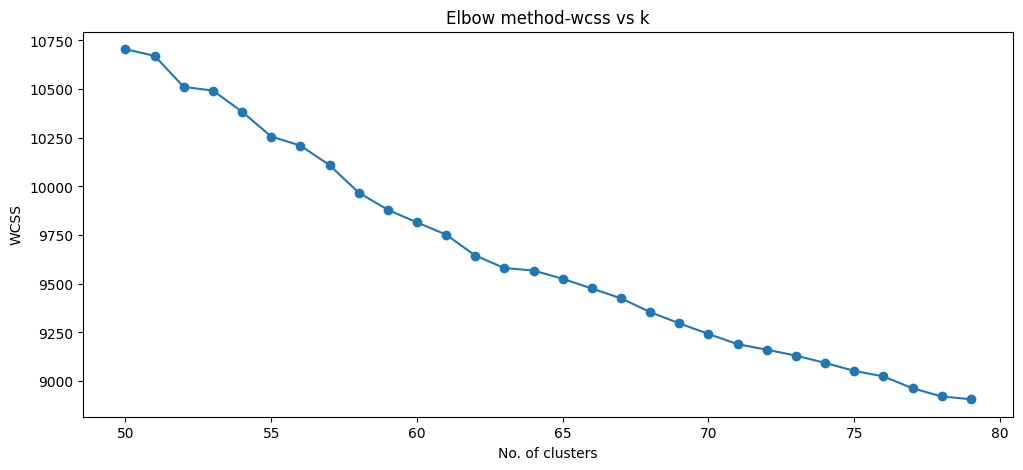

In [232]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(range(50,80),wcss,marker='o')
plt.title("Elbow method-wcss vs k")
plt.xlabel("No. of clusters")
plt.ylabel("WCSS")

Text(0, 0.5, 'WCSS')

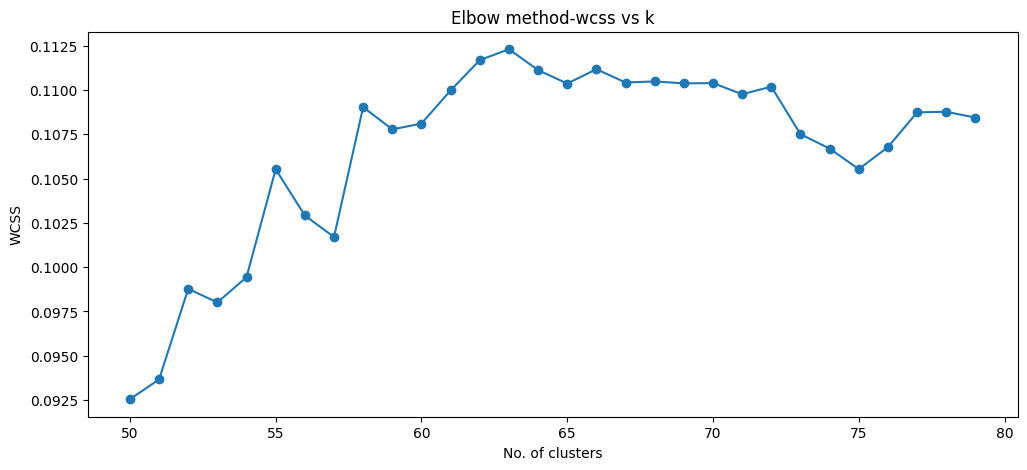

In [233]:
plt.figure(figsize=(12,5))
plt.plot(range(50,80),silhoutte_scores,marker='o')
plt.title("Elbow method-wcss vs k")
plt.xlabel("No. of clusters")
plt.ylabel("WCSS")

In [234]:
from sklearn.metrics import silhouette_score
wcss=[]
silhoutte_scores=[]

for k in range(100,130):
    kmeans=KMeans(n_clusters=k,random_state=42)
    kmeans.fit(x_pca)
    wcss.append(kmeans.inertia_)
    silhoutte_scores.append(silhouette_score(x_pca,kmeans.labels_))

Text(0, 0.5, 'WCSS')

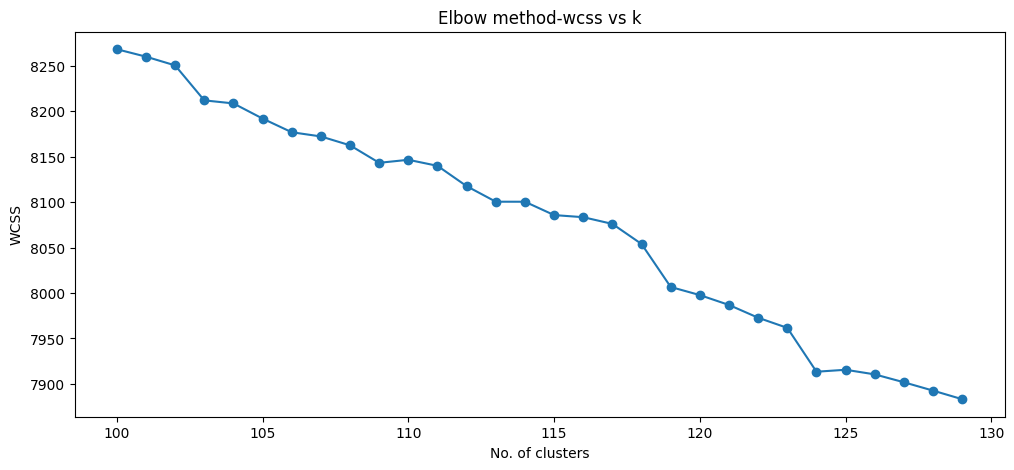

In [235]:
plt.figure(figsize=(12,5))
plt.plot(range(100,130),wcss,marker='o')
plt.title("Elbow method-wcss vs k")
plt.xlabel("No. of clusters")
plt.ylabel("WCSS")

Text(0, 0.5, 'WCSS')

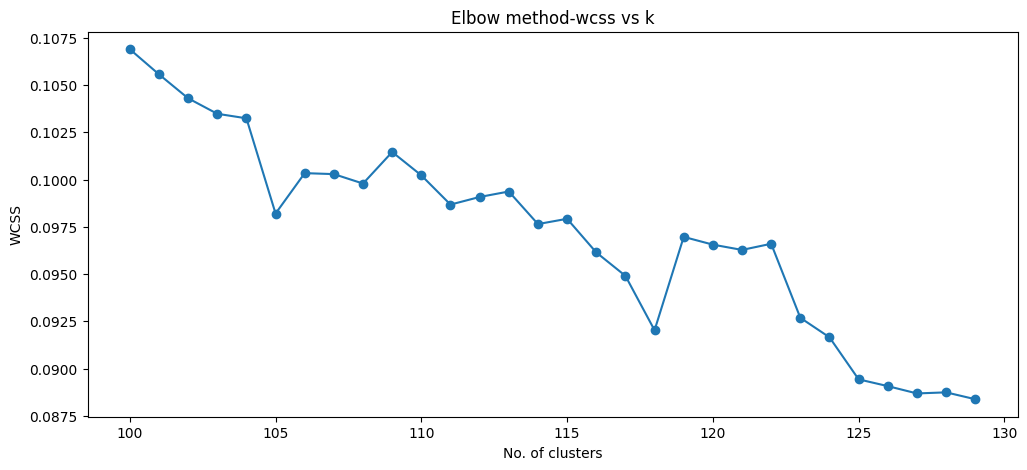

In [236]:
plt.figure(figsize=(12,5))
plt.plot(range(100,130),silhoutte_scores,marker='o')
plt.title("Elbow method-wcss vs k")
plt.xlabel("No. of clusters")
plt.ylabel("WCSS")

# PARTITION